In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [3]:
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
mpl.rcParams['animation.embed_limit'] = 4000

In [4]:
from mmctools.helper_functions import theta, power_spectral_density, calc_spectra
from windtools.common import calc_wind

In [5]:
from windtools.SOWFA6.postProcessing.averaging import PlanarAverages
from windtools.SOWFA6.postProcessing.probes import Probe
from windtools.SOWFA6.postProcessing.probeSets import ProbeSets
from windtools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum
from windtools.vtk import readVTK

In [6]:
def interpolate_to_heights(df,heights):
    """
    Interpolate data in dataframe to specified heights
    and return a new dataframe
    """
    from scipy.interpolate import interp1d
    
    # If single height is asked
    if isinstance(heights, (float,int)):
        heights=[heights]
    
    # Unstack to single height index (= most time-consuming operation)
    unstacked = df.unstack(level='datetime')
    # Interpolate to specified heights
    f = interp1d(unstacked.index,unstacked,axis=0,fill_value='extrapolate')
    for hgt in heights:
        unstacked.loc[hgt] = f(hgt)
    # Restack and set index
    df_out = unstacked.loc[heights].stack().reset_index().set_index(['datetime','height']).sort_index()
    return df_out


# FINO1 Power Spectral Density comparison across codes
This notebook uses processed data, generated by running previous notebooks in the series.

Regis Thedin \
May 2021

In [7]:
# Paths
vtkcasepath = '/projects/mmc/rthedin/OpenFOAM/rthedin-6/run/offshoreCases/02_fino_sampling/'
probecasepath = '/scratch/rthedin/OpenFOAM/rthedin-6/run/offshore/03_fino_sampling/'
obspath = '~/a2e-mmc/assessment/studies/fino_offshore_microscale/'
wrfpath = '/projects/mmc/rthedin/OpenFOAM/rthedin-6/run/offshoreCases'

In [8]:
figdir = os.path.join(vtkcasepath,'figures')
procdatadir = os.path.join(vtkcasepath,'processedFiles')

if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(procdatadir):
    os.makedirs(procdatadir)

## 1. Load data

### Times
Perform operations in time. OpenFOAM only deals with seconds.

- WRF/WTK data comes in `datetime` already and goes from `datefrom` to `dateto`.
- SOWFA time `0` is related to `dateref`. That is done to align the WRF/WTK output to forcing. 


In [9]:
# WRF
datefrom = pd.to_datetime('2010-05-14 12:00:03')
dateto = pd.to_datetime('2010-05-17 00:00:00')

# SOWFA
dateref = pd.to_datetime('2010-05-14 12:00:00')
LESfrom=pd.to_datetime('2010-05-16 01:00:00')
LESto=pd.to_datetime('2010-05-16 05:00:00')
LESspinupfrom = LESfrom - pd.Timedelta(seconds=20000)

### Load SOWFA virtual masts probes dataset (affected by gravity waves)

In [16]:
# read the netCDF file with all probes
dssowfa = xr.open_dataset(os.path.join(procdatadir,'ds_allmasts_01Z_05Z.nc'))

In [18]:
# Calculate wspd and wdir
dssowfa['wspd'], dssowfa['wdir'] = calc_wind(dssowfa)

### Load WRF virtual masts probes
Data sent by Will and Raj executed in WRF using 3 different methods

In [19]:
willpath = os.path.join(procdatadir,'fromWill')

dswrf_control = xr.open_dataset(os.path.join(willpath,'FINO_wrf-tslist-processed_control.nc')).rename({'nz':'height'})
dswrf_cpm = xr.open_dataset(os.path.join(willpath,'FINO_wrf-tslist-processed_cpm.nc')).rename({'nz':'height'})

In [20]:
rajpath = os.path.join(procdatadir,'fromRaj')

temp1 = xr.open_dataset(os.path.join(rajpath, 'twr_ARR04.nc')).expand_dims('station').assign_coords({'station':['ARR04']})
temp2 = xr.open_dataset(os.path.join(rajpath, 'twr_ARR05.nc')).expand_dims('station').assign_coords({'station':['ARR05']})
temp3 = xr.open_dataset(os.path.join(rajpath, 'twr_ARR09.nc')).expand_dims('station').assign_coords({'station':['ARR09']})
temp4 = xr.open_dataset(os.path.join(rajpath, 'twr_ARR10.nc')).expand_dims('station').assign_coords({'station':['ARR10']})

dswrf_raj = xr.concat([temp1,temp2,temp3,temp4], 'station').rename({'time':'datetime'})

In [21]:
dswrf_control['wspd'], dswrf_control['wdir'] = calc_wind(dswrf_control)
dswrf_cpm['wspd'], dswrf_cpm['wdir'] = calc_wind(dswrf_cpm)
dswrf_raj['wspd'], dswrf_raj['wdir'] = calc_wind(dswrf_raj)

### Load observation dataset
High-frequency observation dataset sent by Raj on April 8. Processing and creation of netCDF file available on A2e's github page under `assessment/studies/fino_offshore_microscale/`.

In [28]:
obsrajfull = xr.open_dataset(os.path.join(obspath, 'FINO1_obs_10Hz.nc'))

In [29]:
# Get only the period of interest
obs = obsrajfull.sel(datetime=slice(LESfrom,LESto))

### Load observation dataset sent by Will

In [30]:
obswillfull = xr.open_dataset(os.path.join(obspath,'FINO1_obs_will.nc'))

In [31]:
# Get only the period of interest
obswill = obswillfull.sel(datetime=slice(LESfrom,LESto))

In [32]:
# there are a few extra times on hh:09, even though the hh:10 datapoint is still there. Removing those
obswill = obswill.resample(datetime='10min').nearest()

In [33]:
# Each variable has its own levels. Here we create a single level 'height' and map the data to such level. NaN's are placed into non-existing levels
heights = np.unique(np.concatenate([levels.values for coord,levels in obswill.coords.items() if coord != 'datetime']))

for dvar in obswill.data_vars:
    level = obswill[dvar].dims[0]
    obswill[dvar] = obswill[dvar].reindex({level:heights}).rename({level: 'height'})
    obswill = obswill.drop_vars(level)

## 2. Spectral Analysis

In [34]:
def calc_spectra_chunks(ds, var_oi, times, interval, window_length, spectra_dim, average_dim, level_dim, window='hamming', window_overlap_pct=None):
    """
    Calculate spectra for a given number of times and return a new dataset
    """
    dflist = []
    for tstart in times:
        spectra = calc_spectra(ds,
                      var_oi=var_oi,
                      spectra_dim=spectra_dim,
                      average_dim=average_dim,
                      level_dim=level_dim,
                      window=window,
                      tstart=pd.to_datetime(tstart),
                      interval=interval,
                      window_length=window_length,
                      window_overlap_pct=window_overlap_pct 
                      #level=[0,1]
                     )
        spectra['time'] = pd.to_datetime(tstart)
        spectra = spectra.expand_dims('time').assign_coords({'time':[pd.to_datetime(tstart)]})
        dflist.append(spectra)
    
    df_spectra = xr.concat(dflist,dim='time')
    return df_spectra


In [35]:
spectraTimes = pd.date_range(start=LESfrom, end=LESto, freq='80min')[:-1]

### 2.1 Comparison with WRF
Here a comparison between the WRF runs executed by Will and Raj are presented, alongside the SOWFA and obs results

In [36]:
# Adjust sowfa data so that we have `station` instead of `x` and `y`
dssowfa4x4 = dssowfa.sel(height=[45,65,85], x=[0,1000], y=[0, -1000], method='nearest').resample(datetime='0.4S').nearest()
dssowfa4x4 = xr.concat([dssowfa4x4.isel(x=0,y=0, drop=True).expand_dims('station').assign_coords({'station':[0]}),
                        dssowfa4x4.isel(x=0,y=1, drop=True).expand_dims('station').assign_coords({'station':[1]}),
                        dssowfa4x4.isel(x=1,y=0, drop=True).expand_dims('station').assign_coords({'station':[2]}),
                        dssowfa4x4.isel(x=1,y=1, drop=True).expand_dims('station').assign_coords({'station':[3]})],
                        dim='station')

In [37]:
# Calculate PSD on 80min chunks

psdsowfa4x4ch = calc_spectra_chunks(dssowfa4x4.resample(datetime='0.4S').nearest(),
                                    var_oi='wspd',
                                    spectra_dim='datetime',
                                    times=spectraTimes,
                                    average_dim='station',
                                    level_dim='height',
                                    window='hamming',
                                    interval='80min',
                                    window_length='20min',
                                    window_overlap_pct=0.5)

psdwrf_control4x4ch = calc_spectra_chunks(dswrf_control,
                                    var_oi='wspd',
                                    spectra_dim='datetime',
                                    times=spectraTimes,
                                    average_dim='station',
                                    level_dim='height',
                                    window='hamming',
                                    interval='80min',
                                    window_length='20min',
                                    window_overlap_pct=0.5)

psdwrf_cpm4x4ch = calc_spectra_chunks(dswrf_cpm,
                                    var_oi='wspd',
                                    spectra_dim='datetime',
                                    times=spectraTimes,
                                    average_dim='station',
                                    level_dim='height',
                                    window='hamming',
                                    interval='80min',
                                    window_length='20min',
                                    window_overlap_pct=0.5)

psdwrf_raj4x4ch = calc_spectra_chunks(dswrf_raj,
                                    var_oi='wspd',
                                    spectra_dim='datetime',
                                    times=spectraTimes,
                                    average_dim='station',
                                    level_dim='height',
                                    window='hamming',
                                    interval='80min',
                                    window_length='20min',
                                    window_overlap_pct=0.5)

psdobsch = calc_spectra_chunks(obs,
                                    var_oi='wspd',
                                    spectra_dim='datetime',
                                    times=spectraTimes,
                                    average_dim = None,
                                    level_dim='height',
                                    window='hamming',
                                    interval='80min',
                                    window_length='20min',
                                    window_overlap_pct=0.5)

                          

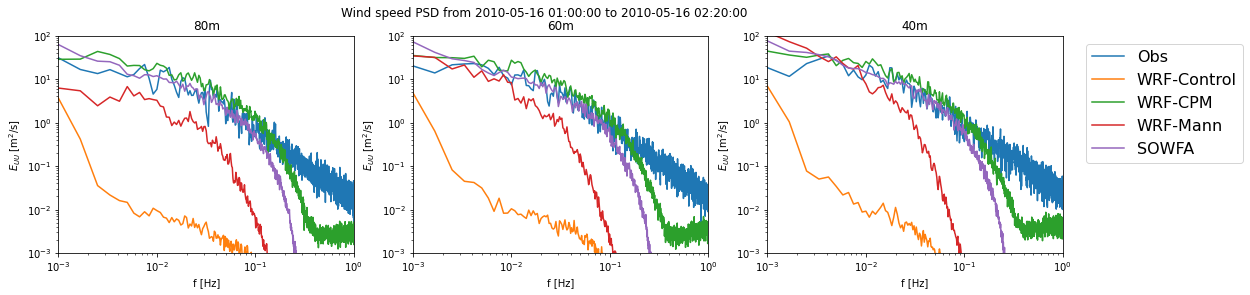

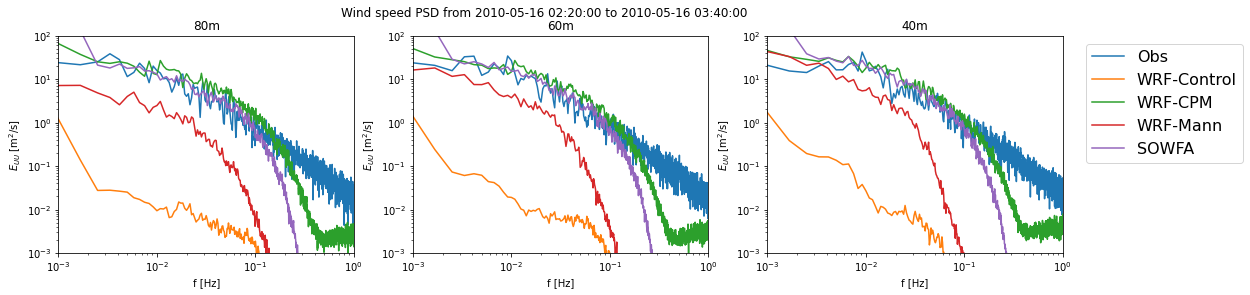

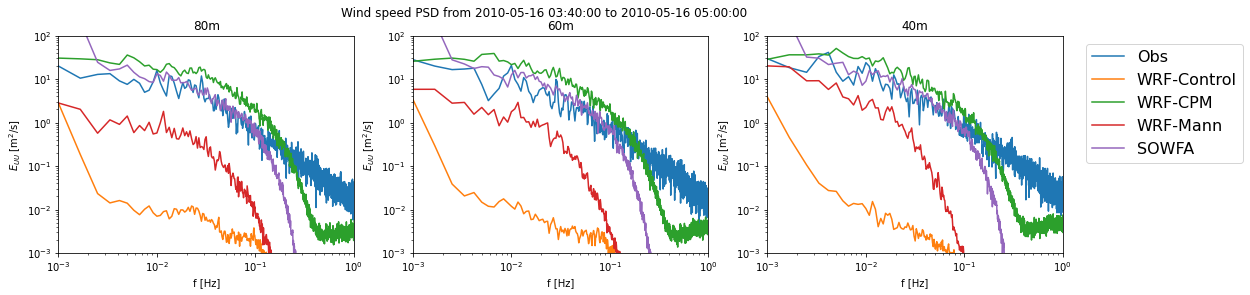

In [38]:
for t in spectraTimes:

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

    _,ax = plot_spectrum(
        datasets={'Obs':psdobsch.sel(time=t, height=80).to_dataframe(), \
                  'WRF-Control':psdwrf_control4x4ch.sel(time=t, height=80).mean(dim='station').to_dataframe(), \
                  'WRF-CPM':  psdwrf_cpm4x4ch.sel(time=t, height=80).mean(dim='station').to_dataframe(), \
                  'WRF-Mann': psdwrf_raj4x4ch.sel(time=t, height=80).mean(dim='station').to_dataframe(), \
                  'SOWFA':psdsowfa4x4ch.sel(time=t, height=85).mean(dim='station').to_dataframe(),
                  },
        #height=80,
        #times=spectraTimes,
        fields='wspd',
        freqlimits=(1e-3,1),
        fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=False,
        fig=fig, ax=axs[0]
    )
    ax.set_title('80m')


    _,ax = plot_spectrum(
        datasets={'Obs':psdobsch.sel(time=t, height=60).to_dataframe(), \
                  'WRF-Control':psdwrf_control4x4ch.sel(time=t, height=60).mean(dim='station').to_dataframe(), \
                  'WRF-CPM':  psdwrf_cpm4x4ch.sel(time=t, height=60).mean(dim='station').to_dataframe(), \
                  'WRF-Mann': psdwrf_raj4x4ch.sel(time=t, height=60).mean(dim='station').to_dataframe(), \
                  'SOWFA':psdsowfa4x4ch.sel(time=t, height=65,method='nearest').mean(dim='station').to_dataframe(),
                 },
        #height=80,
        #times=spectraTimes,
        fields='wspd',
        freqlimits=(1e-3,1),
        fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=False,
        fig=fig, ax=axs[1]
    )
    ax.set_title('60m')


    _,ax = plot_spectrum(
        datasets={'Obs':psdobsch.sel(time=t, height=40).to_dataframe(), \
                  'WRF-Control':psdwrf_control4x4ch.sel(time=t, height=40).mean(dim='station').to_dataframe(), \
                  'WRF-CPM':  psdwrf_cpm4x4ch.sel(time=t, height=40).mean(dim='station').to_dataframe(), \
                  'WRF-Mann': psdwrf_raj4x4ch.sel(time=t, height=40).mean(dim='station').to_dataframe(), \
                  'SOWFA':psdsowfa4x4ch.sel(time=t, height=45,method='nearest').mean(dim='station').to_dataframe(),
                 },
        #height=80,
        #times=spectraTimes,
        fields='wspd',
        freqlimits=(1e-3,1),
        fieldlimits={'wspd':(1e-3,1e2)},
        fig=fig, ax=axs[2]
    )
    ax.set_title('40m')

    fig.suptitle(f"Wind speed PSD from {t} to {t+pd.Timedelta(80, unit='min')}")
    plt.show()

### 2.2. 5Hz SOWFA vs 10Hz obs
Using all 25 masts at 5 Hz frequency from SOWFA

In [42]:
psdsowfa = calc_spectra(dssowfa.sel(y=dssowfa.y[2]),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='x',
                        level_dim='height',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )

psdobs = calc_spectra(obs,
                      var_oi=['u','v','w','wspd'],
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming',
                      window_length='30min',
                     )

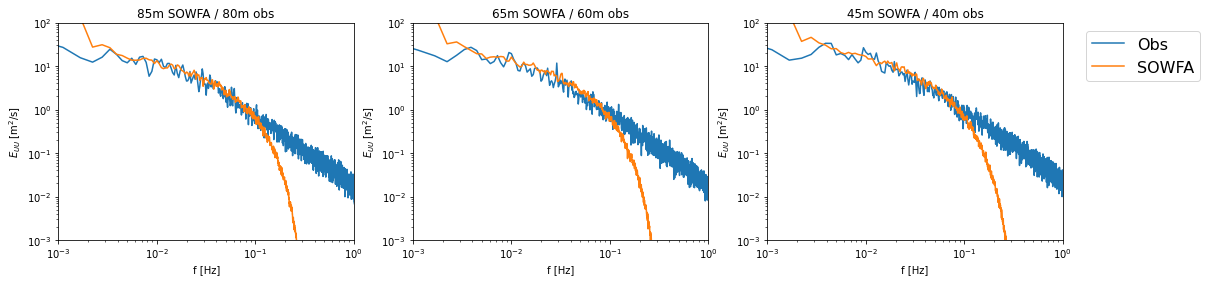

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=80).to_dataframe(), \
              'SOWFA':psdsowfa.sel(height=85).mean(dim='x').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[0]
)
ax.set_title('85m SOWFA / 80m obs')


_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=60).to_dataframe(), \
              'SOWFA':psdsowfa.sel(height=65,method='nearest').mean(dim='x').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[1]
)
ax.set_title('65m SOWFA / 60m obs')


_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=40).to_dataframe(), \
              'SOWFA':psdsowfa.sel(height=45,method='nearest').mean(dim='x').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    fig=fig, ax=axs[2]
)
ax.set_title('45m SOWFA / 40m obs')
plt.show()

## Time-history of mast points

### Obs

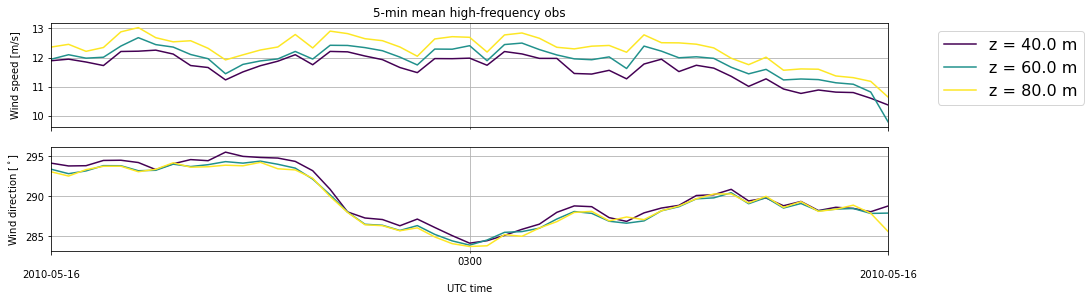

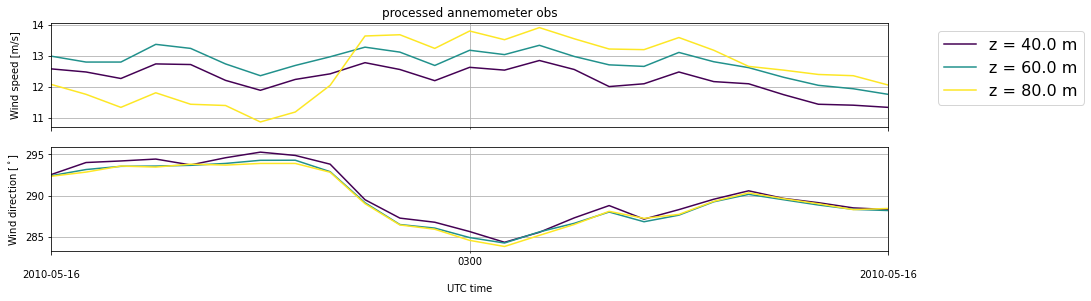

In [44]:
fig,axs = plot_timehistory_at_height(
    obs.resample(datetime='5min').mean(),
    fields=['wspd','wdir'],
    heights=[40,60,80],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    #fieldlimits={'wspd':(11,21),'wdir':(280,310),'theta':(280,283)},
    plot_local_time=False,
    subfigsize=(15,2.1)
)
axs[0].set_title('5-min mean high-frequency obs')

fig,axs = plot_timehistory_at_height(
    obswill,
    fields=['wspd','wdir'],
    heights=[40,60,80],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    #fieldlimits={'wspd':(11,21),'wdir':(280,310),'theta':(280,283)},
    plot_local_time=False,
    subfigsize=(15,2.1)
)
axs[0].set_title('processed annemometer obs')

plt.show()

### Comparison of time histories at specific heights

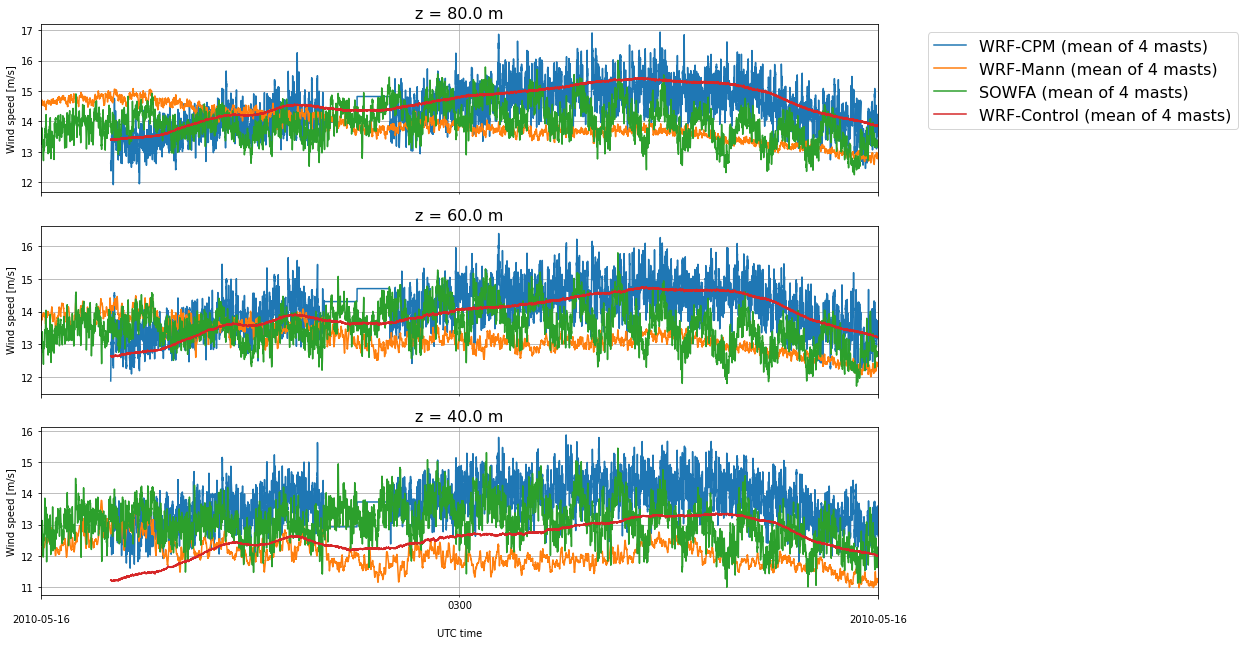

In [53]:
fig,axs = plot_timehistory_at_height(
     datasets={'WRF-CPM (mean of 4 masts)': dswrf_cpm.mean(dim='station'), \
               'WRF-Mann (mean of 4 masts)': dswrf_raj.mean(dim='station'), \
               'SOWFA (mean of 4 masts)':dssowfa4x4.mean(dim='station'), \
               'WRF-Control (mean of 4 masts)': dswrf_control.mean(dim='station'), \
              },
    fields=['wspd'],
    heights=[80,60,40],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    #fieldlimits={'wspd':(12,16),'wdir':(283,303)},
    plot_local_time=False,
    stack_by_datasets=True,
    subfigsize=(15,3.5)
)

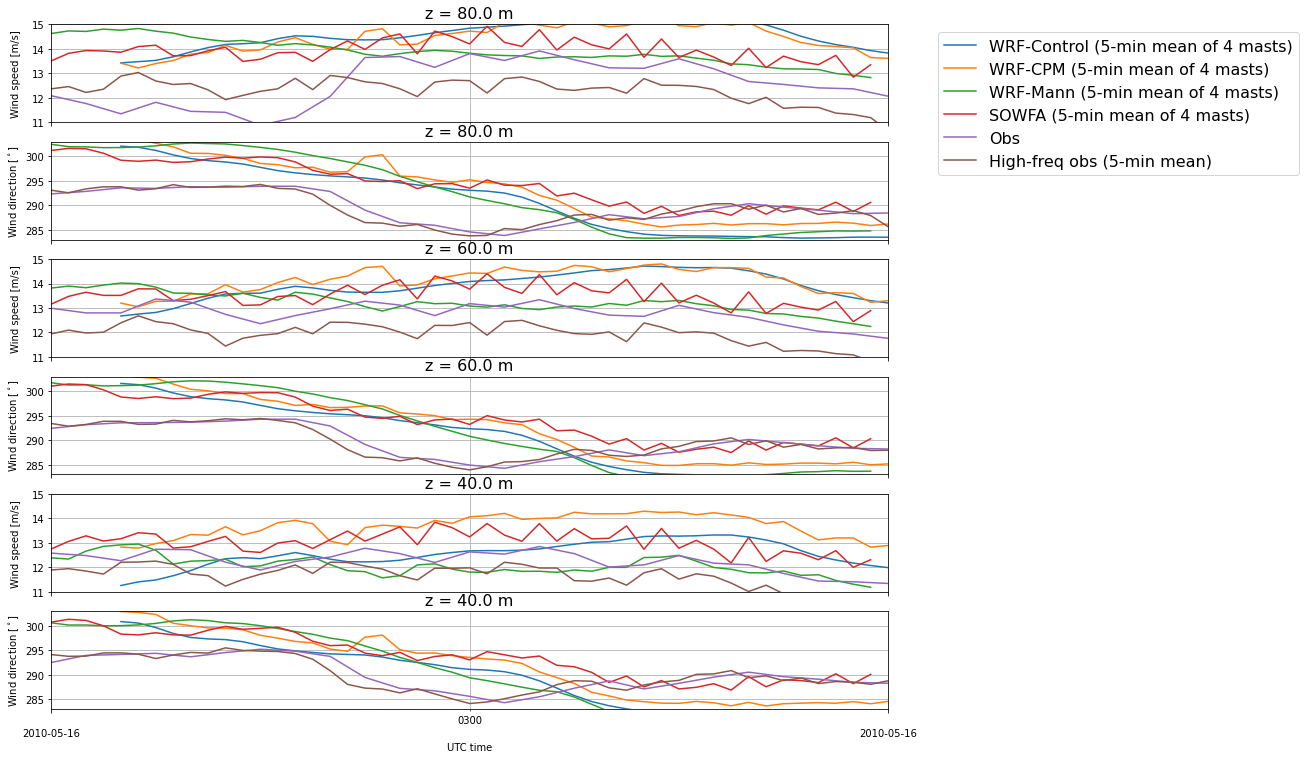

In [55]:
fig,axs = plot_timehistory_at_height(
     datasets={'WRF-Control (5-min mean of 4 masts)': dswrf_control.mean(dim='station').resample(datetime='5min').mean(), \
               'WRF-CPM (5-min mean of 4 masts)': dswrf_cpm.mean(dim='station').resample(datetime='5min').mean(), \
               'WRF-Mann (5-min mean of 4 masts)': dswrf_raj.mean(dim='station').resample(datetime='5min').mean(), \
               'SOWFA (5-min mean of 4 masts)':dssowfa4x4.mean(dim='station').resample(datetime='5min').mean(), \
               #'WRF meso (5-min mean)':dswrf.resample(datetime='5min').mean(),
               'Obs':obswill,
               'High-freq obs (5-min mean)':obs.resample(datetime='5min').mean()
              },
    fields=['wspd','wdir'],
    heights=[80,60,40],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    fieldlimits={'wspd':(11,15),'wdir':(283,303)},
    plot_local_time=False,
    stack_by_datasets=True,
    subfigsize=(15,2.1)
)